In [21]:
# URL='https://people.eecs.berkeley.edu/~taesung_park/CycleGAN/datasets/horse2zebra.zip'
ZIP_FILE='../dataset/horse2zebra.zip'
TARGET_DIR='../dataset/horse2zebra'
# !mkdir -p ../dataset
# !wget -N $URL -O $ZIP_FILE
# !unzip $ZIP_FILE -d ../dataset/
# !rm $ZIP_FILE

# # Adapt to project expected directory heriarchy
# !mkdir -p "$TARGET_DIR/train" "$TARGET_DIR/test"
# !mv "$TARGET_DIR/trainA" "$TARGET_DIR/train/A"
# !mv "$TARGET_DIR/trainB" "$TARGET_DIR/train/B"
# !mv "$TARGET_DIR/testA" "$TARGET_DIR/test/A"
# !mv "$TARGET_DIR/testB" "$TARGET_DIR/test/B"

In [22]:
import glob
import random
import os
import time
import datetime
import sys

from torch.utils.data import Dataset
from PIL import Image
import torchvision.transforms as transforms
from torchvision.utils import save_image

import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader
from torch.autograd import Variable
from PIL import Image
import torch
import numpy as np

import argparse
import itertools

In [23]:
parser = argparse.ArgumentParser()
parser.add_argument('--epoch', type=int, default=0, help='starting epoch')
parser.add_argument('--n_epochs', type=int, default=200, help='number of epochs of training')
parser.add_argument('--batchSize', type=int, default=2, help='size of the batches')
parser.add_argument('--dataroot', type=str, default='../dataset/horse2zebra/', help='root directory of the dataset')
parser.add_argument('--lr', type=float, default=0.0002, help='initial learning rate')
parser.add_argument('--decay_epoch', type=int, default=100, help='epoch to start linearly decaying the learning rate to 0')
parser.add_argument('--size', type=int, default=128, help='size of the data crop (squared assumed)')
parser.add_argument('--input_nc', type=int, default=3, help='number of channels of input data')
parser.add_argument('--output_nc', type=int, default=3, help='number of channels of output data')
parser.add_argument('--cuda', default=True, action='store_true', help='use GPU computation')
parser.add_argument('--n_cpu', type=int, default=8, help='number of cpu threads to use during batch generation')
opt = parser.parse_args('')
print(opt)

Namespace(epoch=0, n_epochs=200, batchSize=2, dataroot='../dataset/horse2zebra/', lr=0.0002, decay_epoch=100, size=128, input_nc=3, output_nc=3, cuda=True, n_cpu=8)


In [24]:
myset = set()
files = []
for filename in os.listdir(os.path.join(TARGET_DIR, 'train', 'B')):
    s = transforms.ToTensor()(Image.open(os.path.join(TARGET_DIR, 'train', 'B', filename))).shape
    myset.add(s)
    if s[0] == 1:
        files.append(filename)
        print(transforms.ToTensor()(Image.open(os.path.join(TARGET_DIR, 'train', 'B', filename)).convert('RGB')).shape)
print(myset)

print(files)

torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
{torch.Size([1, 256, 256]), torch.Size([3, 256, 256])}
['n02391049_226.jpg', 'n02391049_2757.jpg', 'n02391049_2341.jpg', 'n02391049_7503.jpg', 'n02391049_2361.jpg', 'n02391049_8008.jpg', 'n02391049_9726.jpg']


In [25]:
class ImageDataset(Dataset):
    def __init__(self, root, transforms_=None, unaligned=False, mode='train'):
        self.transform = transforms.Compose(transforms_)
        self.unaligned = unaligned

        self.files_A = sorted(glob.glob(os.path.join(root, '%s/A' % mode) + '/*.*'))
        self.files_B = sorted(glob.glob(os.path.join(root, '%s/B' % mode) + '/*.*'))

    def __getitem__(self, index):
        item_A = self.transform(Image.open(self.files_A[index % len(self.files_A)]).convert('RGB'))

        if self.unaligned:
            item_B = self.transform(Image.open(self.files_B[random.randint(0, len(self.files_B) - 1)]).convert('RGB'))
        else:
            item_B = self.transform(Image.open(self.files_B[index % len(self.files_B)]).convert('RGB'))

        return {'A': item_A, 'B': item_B}

    def __len__(self):
        return max(len(self.files_A), len(self.files_B))


In [26]:
class GenConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel) -> None:
        super(GenConvolutionBlock, self).__init__()
        padding = kernel // 2
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel, stride=1, padding=padding, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)


In [27]:
class DisConvolutionBlock(nn.Module):
    def __init__(self, in_channels, out_channels, is_last_layer=False) -> None:
        super(DisConvolutionBlock, self).__init__()
        out_channels = 1 if is_last_layer else out_channels
        self.layers = nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=4,
                stride=2,
                padding=1,
                padding_mode="reflect",
                bias=False,
            ),
            *[nn.Sigmoid()]
            if is_last_layer
            else [nn.InstanceNorm2d(out_channels), nn.LeakyReLU(0.02, inplace=True)],
        )

    def forward(self, x):
        return self.layers(x)


In [28]:
class DownsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(DownsamplingBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, padding_mode='reflect', bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True),
        )

    def forward(self, x):
        return self.layers(x)


In [29]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(ResidualBlock, self).__init__()

        self.layers = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, padding_mode='reflect'),
        )

    def forward(self, x):
        return x + self.layers(x)


In [30]:
class UpsamplingBlock(nn.Module):
    def __init__(self, in_channels, out_channels) -> None:
        super(UpsamplingBlock, self).__init__()
        self.layers = nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.InstanceNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.layers(x)

In [31]:
import re

generator_layers_config = [
    "c7s1-64",
    "d128",
    "d256",
    *("R256" for _ in range(6)),
    "u128",
    "u64",
    "c7s1-3",
]


class Generator(nn.Module):
    def __init__(self, input_nc, output_nc, layers_config=generator_layers_config):
        super(Generator, self).__init__()

        # Generator Model
        model = []
        in_channels = input_nc
        for layer_config in layers_config:
            type = layer_config[0:1]
            if type == "c":
                kernel_size, _, out_channels = (
                    int(outs)
                    for outs in re.match("c(.+)s(.+)-(.+)", layer_config).groups()
                )
                model.append(GenConvolutionBlock(in_channels, out_channels, kernel_size))
                in_channels = out_channels
            elif type == "d":
                out_channels = int(layer_config[1:])
                model.append(DownsamplingBlock(in_channels, out_channels))
                in_channels = out_channels
            elif type == "R":
                out_channels = int(layer_config[1:])
                model.append(ResidualBlock(in_channels, out_channels))
                in_channels = out_channels
            elif type == "u":
                out_channels = int(layer_config[1:])
                model.append(UpsamplingBlock(in_channels, out_channels))
                in_channels = out_channels
        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)

generator = Generator(3, 3)
print(generator)
generator(torch.zeros((1, 3, 256, 256))).shape

Generator(
  (model): Sequential(
    (0): GenConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (1): DownsamplingBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (2): DownsamplingBlock(
      (layers): Sequential(
        (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU(inplace=True)
      )
    )
    (3): ResidualBloc

torch.Size([1, 3, 256, 256])

In [32]:
discriminator_layers_config = [
    "C64",
    "C128",
    "C256",
    "C512",
]


class Discriminator(nn.Module):
    def __init__(self, input_nc, layers_config=discriminator_layers_config):
        super(Discriminator, self).__init__()

        # Discriminator Model
        model = []
        in_channels = input_nc
        for layer_config in layers_config:
            type = layer_config[0:1]
            if type == "C":
                out_channels = int(layer_config[1:])
                model.append(DisConvolutionBlock(in_channels, out_channels))
                in_channels = out_channels
        model.append(DisConvolutionBlock(in_channels, 1, True))
        self.model = nn.Sequential(*model)

    def forward(self, x):
        x = self.model(x)
        # Average pooling and flatten
        return F.avg_pool2d(x, x.size()[2:]).view(x.size()[0], -1)

discriminator = Discriminator(3)
print(discriminator)
discriminator(torch.zeros(4, 3, 256, 256)).shape

Discriminator(
  (model): Sequential(
    (0): DisConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.02, inplace=True)
      )
    )
    (1): DisConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.02, inplace=True)
      )
    )
    (2): DisConvolutionBlock(
      (layers): Sequential(
        (0): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False, padding_mode=reflect)
        (1): InstanceNorm2d(256, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
       

torch.Size([4, 1])

In [33]:
# Lossess
criterion_GAN = torch.nn.MSELoss()
criterion_cycle = torch.nn.L1Loss()
criterion_identity = torch.nn.L1Loss()

In [34]:
if torch.cuda.is_available() and not opt.cuda:
    print("WARNING: You have a CUDA device, so you should probably run with --cuda")

In [35]:
def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        torch.nn.init.normal(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm2d') != -1:
        torch.nn.init.normal(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant(m.bias.data, 0.0)

class LambdaLR():
    def __init__(self, n_epochs, offset, decay_start_epoch):
        assert ((n_epochs - decay_start_epoch) > 0), "Decay must start before the training session ends!"
        self.n_epochs = n_epochs
        self.offset = offset
        self.decay_start_epoch = decay_start_epoch

    def step(self, epoch):
        return 1.0 - max(0, epoch + self.offset - self.decay_start_epoch)/(self.n_epochs - self.decay_start_epoch)

class ReplayBuffer():
    def __init__(self, max_size=50):
        assert (max_size > 0), 'Empty buffer or trying to create a black hole. Be careful.'
        self.max_size = max_size
        self.data = []

    def push_and_pop(self, data):
        to_return = []
        for element in data.data:
            element = torch.unsqueeze(element, 0)
            if len(self.data) < self.max_size:
                self.data.append(element)
                to_return.append(element)
            else:
                if random.uniform(0,1) > 0.5:
                    i = random.randint(0, self.max_size-1)
                    to_return.append(self.data[i].clone())
                    self.data[i] = element
                else:
                    to_return.append(element)
        return Variable(torch.cat(to_return))

In [36]:
# Networks
netG_A2B = Generator(opt.input_nc, opt.output_nc)
netG_B2A = Generator(opt.output_nc, opt.input_nc)
netD_A = Discriminator(opt.input_nc)
netD_B = Discriminator(opt.output_nc)

if opt.cuda:
    netG_A2B.cuda()
    netG_B2A.cuda()
    netD_A.cuda()
    netD_B.cuda()

# netG_A2B.apply(weights_init_normal)
# netG_B2A.apply(weights_init_normal)
# netD_A.apply(weights_init_normal)
# netD_B.apply(weights_init_normal)

In [37]:
# Optimizers & LR schedulers
optimizer_G = torch.optim.Adam(itertools.chain(netG_A2B.parameters(), netG_B2A.parameters()),
                                lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_A = torch.optim.Adam(netD_A.parameters(), lr=opt.lr, betas=(0.5, 0.999))
optimizer_D_B = torch.optim.Adam(netD_B.parameters(), lr=opt.lr, betas=(0.5, 0.999))

lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)
lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(opt.n_epochs, opt.epoch, opt.decay_epoch).step)


In [38]:
# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)
target_real = Variable(Tensor(opt.batchSize).fill_(1.0), requires_grad=False)
target_fake = Variable(Tensor(opt.batchSize).fill_(0.0), requires_grad=False)

fake_A_buffer = ReplayBuffer()
fake_B_buffer = ReplayBuffer()

In [39]:
# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size*1.12), Image.BICUBIC), 
                transforms.RandomCrop(opt.size), 
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, unaligned=True), 
                        batch_size=opt.batchSize, shuffle=True, num_workers=opt.n_cpu)

In [40]:
###### Training ######
for epoch in range(opt.epoch, opt.n_epochs):
    for i, batch in enumerate(dataloader):
        # Set model input
        real_A = Variable(input_A.copy_(batch['A']))
        real_B = Variable(input_B.copy_(batch['B']))

        ###### Generators A2B and B2A ######
        optimizer_G.zero_grad()

        # Identity loss (lambda=5)
        # G_A2B(B) should equal B if real B is fed     
        loss_identity_A = criterion_identity(netG_B2A(real_A), real_A) * 5.0

        # G_B2A(A) should equal A if real A is fed
        loss_identity_B = criterion_identity(netG_A2B(real_B), real_B) * 5.0

        # GAN loss (lambda=1)
        fake_A = netG_B2A(real_B)
        fake_B = netG_A2B(real_A)
        pred_A = netD_A(fake_A)
        pred_B = netD_B(fake_B)
        loss_GAN_A2B = criterion_GAN(pred_B, target_real)
        loss_GAN_B2A = criterion_GAN(pred_A, target_real)

        # Cycle loss (lambda=10)
        fake_ABA = netG_B2A(fake_B)
        fake_BAB = netG_A2B(fake_A)
        loss_cycle_ABA = criterion_cycle(fake_ABA, real_A) * 10.0
        loss_cycle_BAB = criterion_cycle(fake_BAB, real_B) * 10.0

        # Total loss
        loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
        loss_G.backward()

        optimizer_G.step()
        ###################################

        ###### Discriminator A ######
        optimizer_D_A.zero_grad()

        # Real loss
        pred_real_A = netD_A(real_A)
        loss_D_real = criterion_GAN(pred_real_A, target_real)

        # Fake loss
        fake_A = netG_B2A(real_B)
        pred_fake_A = netD_A(fake_A)
        loss_D_fake = criterion_GAN(pred_fake_A, target_fake)

        # Total loss
        loss_D_A = (loss_D_real + loss_D_fake)*0.5
        loss_D_A.backward()

        optimizer_D_A.step()
        ###################################

        ###### Discriminator B ######
        optimizer_D_B.zero_grad()

        # Real loss
        pred_real_B = netD_B(real_B)
        loss_D_real = criterion_GAN(pred_real_B, target_real)
        
        # Fake loss
        fake_B = netG_A2B(real_A)
        pred_fake_B = netD_B(fake_B)
        loss_D_fake = criterion_GAN(pred_fake_B, target_fake)

        # Total loss
        loss_D_B = (loss_D_real + loss_D_fake)*0.5
        loss_D_B.backward()

        optimizer_D_B.step()
        ###################################
        print(
            f'\repoch:{epoch+1}/{opt.n_epochs} batch:{i + 1}/{len(dataloader)}'
            + f' | ra:{pred_real_A.mean():.4f}'
            + f' | fa:{pred_fake_A.mean():.4f}'
            + f' | rb:{pred_real_B.mean():.4f}'
            + f' | fb:{pred_fake_B.mean():.4f}'
            + f' | lg:{loss_G:.4f}'
            + f' | la:{loss_D_A:.4f}'
            + f' | lb:{loss_D_B:.4f}',
            end='',
        )
    print('\r', end="")
    print(f'epoch:{epoch+1}/{opt.n_epochs}')
    print(f'  pred_real_A:{pred_real_A.mean():.4f} | pred_fake_A:{pred_fake_A.mean():.4f}')
    print(f'  pred_real_B:{pred_real_B.mean():.4f} | pred_fake_B:{pred_fake_B.mean():.4f}')
    print(f'  loss_G:{loss_G:.4f} | loss_D_A:{loss_D_A:.4f} | loss_D_B:{loss_D_B:.4f}')

    # Update learning rates
    lr_scheduler_G.step()
    lr_scheduler_D_A.step()
    lr_scheduler_D_B.step()

    # Save models checkpoints
    torch.save(netG_A2B.state_dict(), 'output/netG_A2B.pth')
    torch.save(netG_B2A.state_dict(), 'output/netG_B2A.pth')
    torch.save(netD_A.state_dict(), 'output/netD_A.pth')
    torch.save(netD_B.state_dict(), 'output/netD_B.pth')
###################################

/home/minhyuk/miniconda3/envs/torch/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([2])) that is different to the input size (torch.Size([2, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


epoch:1/200 batch:667/667 | ra:0.9673 | fa:0.1661 | rb:0.9573 | fb:0.1524 | lg:11.6601 | la:0.0149 | lb:0.0179
  pred_real_A:0.9673 | pred_fake_A:0.1661
  pred_real_B:0.9573 | pred_fake_B:0.1524
  loss_G:11.6601 | loss_D_A:0.0149 | loss_D_B:0.0179
epoch:2/200 batch:667/667 | ra:0.6800 | fa:0.2603 | rb:0.9227 | fb:0.2603 | lg:9.6157 | la:0.1116 | lb:0.05614
  pred_real_A:0.6800 | pred_fake_A:0.2603
  pred_real_B:0.9227 | pred_fake_B:0.2603
  loss_G:9.6157 | loss_D_A:0.1116 | loss_D_B:0.0561
epoch:3/200 batch:667/667 | ra:0.7711 | fa:0.3364 | rb:0.9158 | fb:0.1115 | lg:11.4581 | la:0.0889 | lb:0.0109
  pred_real_A:0.7711 | pred_fake_A:0.3364
  pred_real_B:0.9158 | pred_fake_B:0.1115
  loss_G:11.4581 | loss_D_A:0.0889 | loss_D_B:0.0109
epoch:4/200 batch:667/667 | ra:0.8181 | fa:0.2332 | rb:0.9824 | fb:0.0741 | lg:14.8679 | la:0.0443 | lb:0.0032
  pred_real_A:0.8181 | pred_fake_A:0.2332
  pred_real_B:0.9824 | pred_fake_B:0.0741
  loss_G:14.8679 | loss_D_A:0.0443 | loss_D_B:0.0032
epoch:5/2

In [45]:
###### Testing######

# Set model's test mode
netG_A2B.eval()
netG_B2A.eval()

# Inputs & targets memory allocation
Tensor = torch.cuda.FloatTensor if opt.cuda else torch.Tensor
input_A = Tensor(opt.batchSize, opt.input_nc, opt.size, opt.size)
input_B = Tensor(opt.batchSize, opt.output_nc, opt.size, opt.size)

# Dataset loader
transforms_ = [ transforms.Resize(int(opt.size), Image.BICUBIC), transforms.ToTensor(),
                transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5)) ]
dataloader = DataLoader(ImageDataset(opt.dataroot, transforms_=transforms_, mode='test'), 
                        batch_size=opt.batchSize, shuffle=False, num_workers=opt.n_cpu)

In [46]:
# Create output dirs if they don't exist
if not os.path.exists('output/A'):
    os.makedirs('output/A')
if not os.path.exists('output/B'):
    os.makedirs('output/B')

for i, batch in enumerate(dataloader):
    # Set model input
    real_A = Variable(input_A.copy_(batch['A']))
    real_B = Variable(input_B.copy_(batch['B']))

    # Generate output
    fake_B = 0.5*(netG_A2B(real_A).data + 1.0)
    fake_A = 0.5*(netG_B2A(real_B).data + 1.0)

    # Save image files
    save_image(fake_A, 'output/A/%04d.png' % (i+1))
    save_image(fake_B, 'output/B/%04d.png' % (i+1))

    sys.stdout.write('\rGenerated images %04d of %04d' % (i+1, len(dataloader)))

sys.stdout.write('\n')

Generated images 0070 of 0070


1

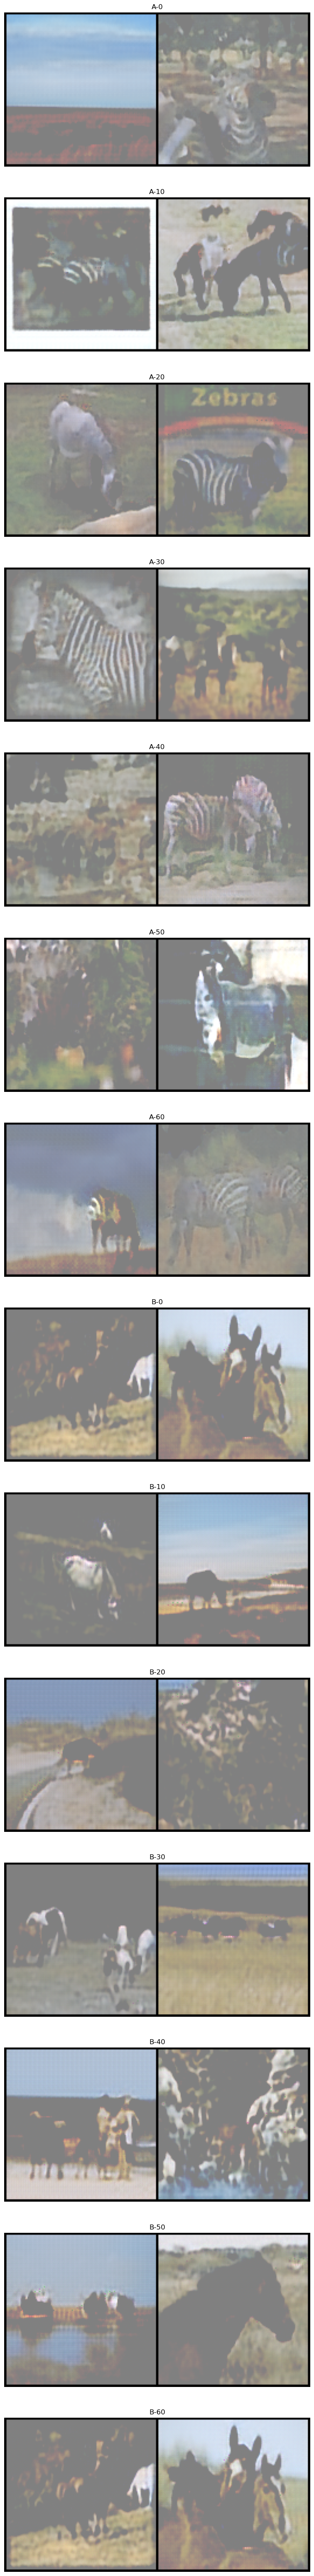

In [64]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(80, 80))
row = 14
col = 1
i = 1
for idx, filename in enumerate(sorted(os.listdir(os.path.join('output', 'A')))):
    if idx % 10 == 0:
        ax = fig.add_subplot(row, col, i)
        ax.imshow(plt.imread(os.path.join('output', 'A', filename)))
        ax.set_title(f'A-{idx}')
        ax.axis('off')
        i += 1
for idx, filename in enumerate(sorted(os.listdir(os.path.join('output', 'B')))):
    if idx % 10 == 0:
        ax = fig.add_subplot(row, col, i)
        ax.imshow(plt.imread(os.path.join('output', 'B', filename)))
        ax.set_title(f'B-{idx}')
        ax.axis('off')
        i += 1
plt.show()